In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kmedoids import KMedoids
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px

In [6]:
X = pd.read_csv('../dataset/FM24_engineered_features.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
results = []
Ks = range(2, 11)

for k in Ks:
    kmedoids = KMedoids(n_clusters=k, metric='euclidean', method='alternate')

    kmedoids.fit(X_scaled)
    labels = kmedoids.labels_

    sil = silhouette_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)
    results.append({
        "k": k,
        "silhouette": sil,
        "davies_bouldin": db
    })

In [8]:
df_k_results = pd.DataFrame(results)
print("\nCluster quality:")
print(df_k_results)


Cluster quality:
    k  silhouette  davies_bouldin
0   2    0.317958        1.423053
1   3    0.172069        1.684633
2   4    0.192034        1.606510
3   5    0.161319        1.795746
4   6    0.131762        1.762108
5   7    0.132141        1.735651
6   8    0.125076        1.836833
7   9    0.119483        1.931615
8  10    0.117346        1.719129


In [9]:
best_row = df_k_results.sort_values("silhouette", ascending=False).iloc[0]
best_k = int(best_row["k"])
print("\nBest K:", best_k)

best_model = KMedoids(n_clusters=best_k, metric='euclidean', method='alternate')
best_model.fit(X_scaled)

final_labels = best_model.labels_
medoid_indices = best_model.medoid_indices_
medoids = X_scaled[medoid_indices]


Best K: 2


In [10]:
df_engineered = pd.read_csv('../dataset/FM24_engineered_features.csv')
df_meta = pd.read_csv('../dataset/fm24_midfielder_metadata.csv')
df_engineered["Cluster"] = final_labels
df_with_clusters = df_meta.join(df_engineered[["Cluster"]])

In [11]:
df_medoids = df_with_clusters.iloc[medoid_indices].copy()

In [12]:
print("\nRepresentative medoid players per cluster:")
print(df_medoids[["Name", "Club", "Nat", "Age", "CA", "PA", "Cluster"]])

print("\nCluster sizes:")
print(df_engineered["Cluster"].value_counts().sort_index())


Representative medoid players per cluster:
               Name       Club  Nat  Age   CA   PA  Cluster
475  Mohamed Camara  AS Monaco  MLI   23  137  151        0
51    Florian Wirtz   Bayer 04  GER   20  152  182        1

Cluster sizes:
Cluster
0     714
1    1107
Name: count, dtype: int64


In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

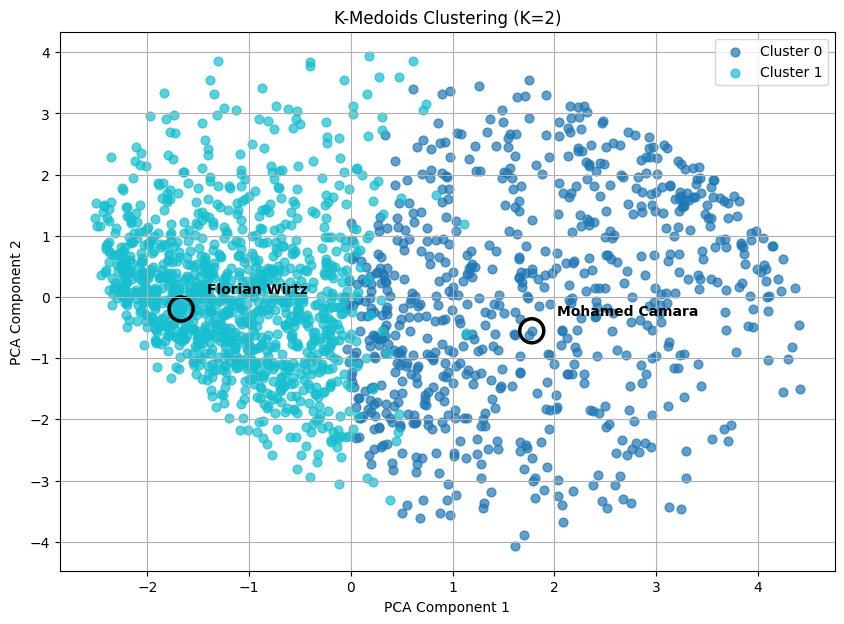

In [14]:
clusters = np.unique(final_labels)

plt.figure(figsize=(10, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    mask = (final_labels == cluster)
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1], 
        s=40, 
        c=[color], 
        label=f"Cluster {cluster}", 
        alpha=0.70
    )

for i, m in enumerate(medoid_indices):
    plt.scatter(
        X_pca[m, 0], 
        X_pca[m, 1], 
        s=300, 
        edgecolors="black",
        facecolors="none", 
        linewidths=2.5, 
        marker="o"
    )
    # Add player name next to medoid
    name = df_with_clusters.iloc[m]["Name"]
    plt.text(
        X_pca[m, 0]+0.25, 
        X_pca[m, 1]+0.25, 
        name, 
        fontsize=10, 
        fontweight="bold"
    )

plt.title(f'K-Medoids Clustering (K={best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df_plot = pd.DataFrame({
    "x": X_pca[:, 0],
    "y": X_pca[:, 1],
    "Cluster": final_labels,
    "Name": df_with_clusters["Name"].values,
    "Club": df_with_clusters["Club"].values,
    "CA": df_with_clusters["CA"].values,
    "PA": df_with_clusters["PA"].values,
})

df_plot["is_medoid"] = False
df_plot.loc[medoid_indices, "is_medoid"] = True

fig = px.scatter(
    df_plot,
    x="x",
    y="y",
    color="Cluster",
    hover_data=["Name", "Club", "CA", "PA"],
    title=f"K-Medoids Clustering (K={best_k}) - PCA Projection",
    opacity=0.8,
)

medoids_df = df_plot[df_plot["is_medoid"]]

fig.add_scatter(
    x=medoids_df["x"],
    y=medoids_df["y"],
    mode="markers+text",
    marker=dict(
        size=18,
        symbol="circle-open",
        line=dict(width=2, color="black"),
    ),
    text=medoids_df["Name"],
    textposition="top center",
    hoverinfo="text",
    name="Medoids",
)

fig.update_layout(
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    legend_title="Cluster",
)

fig.show()

In [16]:
engineered_features = [
    "feat_PassingTechnique",
    "feat_CreativityVision",
    "feat_BallRetention",
    "feat_DefensiveWork",
    "feat_PhysicalPower",
    "feat_Mobility",
    "feat_ProgressivePassing",
    "feat_FirstContact"
]

df_engineered.groupby("Cluster")[engineered_features].mean()

,feat_PassingTechnique,feat_CreativityVision,feat_BallRetention,feat_DefensiveWork,feat_PhysicalPower,feat_Mobility,feat_ProgressivePassing,feat_FirstContact
Cluster,,,,,,,,
0,0.040737,-0.542093,-0.169715,0.840127,-0.748654,0.885535,-0.327648,0.021712
1,0.728980,0.090995,0.183768,-0.406751,-1.762411,0.226829,0.334052,0.604537


In [17]:
df_with_clusters.groupby("Cluster")["Name"].count()

Cluster
0     714
1    1107
Name: Name, dtype: int64

In [18]:
df_with_clusters.groupby("Cluster")["CA"].median()

Cluster
0    81.0
1    84.0
Name: CA, dtype: float64

In [19]:
df_with_clusters.groupby("Cluster")["PA"].median()

Cluster
0    124.0
1    128.0
Name: PA, dtype: float64

In [20]:
df_with_clusters.groupby("Cluster")["Age"].mean()

Cluster
0    20.579832
1    20.516712
Name: Age, dtype: float64

In [21]:
for c in df_with_clusters["Cluster"].unique():
    print(f"\n=== Cluster {c}: Top 10 by CA ===")
    display(
        df_with_clusters[df_with_clusters["Cluster"] == c]
        [["Name","Club","CA","PA"]]
        .sort_values("CA", ascending=False)
        .head(10)
    )


=== Cluster 1: Top 10 by CA ===


,Name,Club,CA,PA
0,Harry Kane,FC Bayern,184,185
1,Jude Bellingham,R. Madrid,177,188
2,Joshua Kimmich,FC Bayern,174,183
9,Martin Ødegaard,Arsenal,173,180
5,Luka Modrić,R. Madrid,171,180
7,Bruno Fernandes,Man UFC,171,174
3,Leroy Sané,FC Bayern,169,172
14,İlkay Gündoğan,Barcelona,167,167
15,Frenkie de Jong,Barcelona,165,181
27,Bruno Guimarães,Newcastle,165,170



=== Cluster 0: Top 10 by CA ===


,Name,Club,CA,PA
6,Declan Rice,Arsenal,176,182
8,Eduardo Camavinga,R. Madrid,170,180
11,Federico Valverde,R. Madrid,168,175
18,Leon Goretzka,FC Bayern,157,170
136,Yves Bissouma,Tottenham,157,165
24,Aurélien Tchouameni,R. Madrid,157,177
16,Casemiro,Man UFC,157,170
115,Moisés Caicedo,Chelsea,156,185
90,Rodrigo Bentancur,Tottenham,156,164
34,Mason Mount,Man UFC,156,170
